In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


**IMPORTING REQUIRED LIBRARIES**

In [2]:
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from scipy.stats import zscore


**DATA LOADING**

In [3]:
#Loading the dataset
train = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')
submission = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv')


**EXPLORATORY DATA ANALYSIS**

In [4]:
#Number of Rows and Columns
print("Train data shape:",train.shape)
print("Test data shape:",test.shape)

Train data shape: (40000, 12)
Test data shape: (10000, 11)


In [5]:
#first and last 5 records
train.head()
train.tail()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price
39995,39995,Vistara,UK-940,Mumbai,NaN,one,Evening,Bangalore,Economy,21.25,43.0,6450
39996,39996,Vistara,UK-720,Kolkata,Early_Morning,one,Night,Mumbai,Business,14.08,12.0,64831
39997,39997,NaN,UK-874,Hyderabad,Morning,one,Night,Bangalore,Economy,14.33,NaN,8062
39998,39998,Vistara,UK-940,Mumbai,NaN,one,Night,Bangalore,Business,24.67,4.0,84557
39999,39999,GO_FIRST,G8-511,Mumbai,Early_Morning,one,Evening,Bangalore,Economy,14.33,NaN,5102


In [6]:
#Columns
train.columns.tolist()

['id',
 'airline',
 'flight',
 'source',
 'departure',
 'stops',
 'arrival',
 'destination',
 'class',
 'duration',
 'days_left',
 'price']

In [7]:
#Summary of dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40000 non-null  int64  
 1   airline      35387 non-null  object 
 2   flight       40000 non-null  object 
 3   source       40000 non-null  object 
 4   departure    35208 non-null  object 
 5   stops        37681 non-null  object 
 6   arrival      40000 non-null  object 
 7   destination  40000 non-null  object 
 8   class        40000 non-null  object 
 9   duration     36987 non-null  float64
 10  days_left    35562 non-null  float64
 11  price        40000 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB


In [8]:
#summary stats
train.describe()

,id,duration,days_left,price
count,40000.00000,36987.000000,35562.000000,40000.00000
mean,19999.50000,12.004088,26.197936,20801.49025
std,11547.14972,7.108063,13.469232,22729.14842
min,0.00000,0.830000,1.000000,1105.00000
25%,9999.75000,6.670000,15.000000,4687.00000
50%,19999.50000,11.080000,26.000000,7353.00000
75%,29999.25000,15.920000,38.000000,42521.00000
max,39999.00000,47.080000,49.000000,114704.00000


In [9]:
#missing values in each column
train.isnull().sum().sort_values(ascending=False).head(10)

departure      4792
airline        4613
days_left      4438
duration       3013
stops          2319
id                0
flight            0
source            0
arrival           0
destination       0
dtype: int64

In [10]:
#unique values in each column
train.nunique().sort_values(ascending=True).tail(15)


class              2
stops              3
airline            6
source             6
departure          6
arrival            6
destination        6
days_left         49
duration         416
flight           869
price           5875
id             40000
dtype: int64

In [11]:
#categorical columns
cat_cols = train.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['airline', 'flight', 'source', 'departure', 'stops', 'arrival', 'destination', 'class']


In [12]:
#numeric columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", num_cols)


Numerical columns: ['id', 'duration', 'days_left', 'price']


**DATA VISUALIZATION**

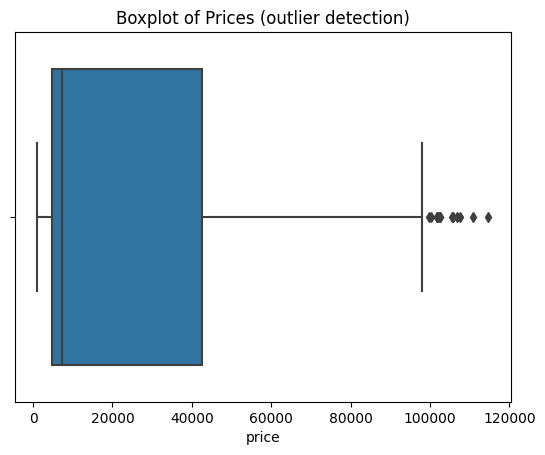

In [13]:
import seaborn as sns
#box plot for outlier detection
sns.boxplot(x=train['price'])
plt.title("Boxplot of Prices (outlier detection)")
plt.show()

**Insight 1:**

a)The flight price data is right-skewed.

b)High-value outliers could heavily influence model training and increase prediction errors unless handled.

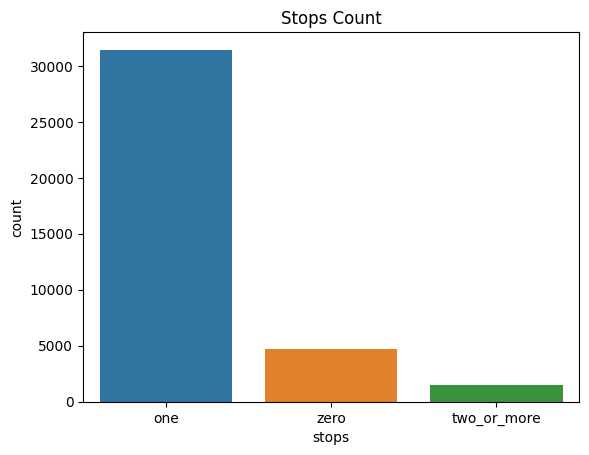

In [14]:
#Stop Count Bar chart
sns.countplot(data=train, x='stops')
plt.title("Stops Count")
plt.show()

**Insight 2:**

a)The stops feature is categorical and imbalanced.

b)Since "one stop" is dominant, models may be biased toward this category.

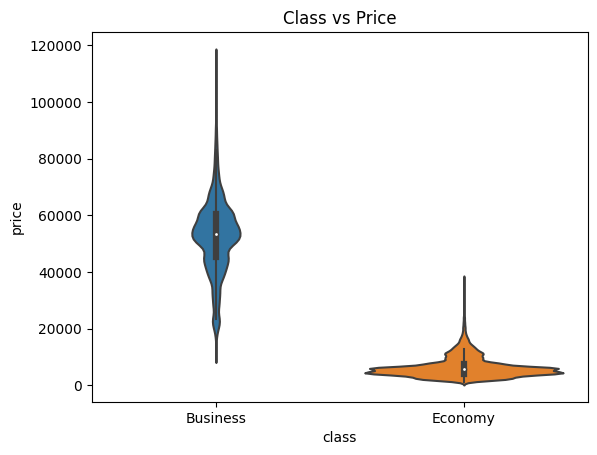

In [15]:
#Violin plot for Class vs Price
sns.violinplot(x='class', y='price', data=train)
plt.title("Class vs Price")
plt.show()

**Insight 3:**

a)There is a clear separation between price distributions for Business and Economy class.

b)Flight class is a very strong predictor of price and must be included in the model.



**DATA CLEANING**

In [16]:
# Count duplicate rows
duplicate_count = train.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")
#Duplicate rows
duplicates = train[train.duplicated()]
display(duplicates)
# Remove duplicate rows
train = train.drop_duplicates()
print(f"Shape after removing duplicates: {train.shape}")
# Fill missing values using forward fill (or mode/mean later)
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
# Remove outliers using Z-score
z_scores = np.abs(zscore(train[['price', 'days_left']]))
train = train[(z_scores < 3).all(axis=1)]


Total duplicate rows: 0


,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price


Shape after removing duplicates: (40000, 12)


/tmp/ipykernel_13/357107042.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
/tmp/ipykernel_13/357107042.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


**COLUMN CATEGORIZATION AND FEATURE ENGINEERING**

In [17]:
#Classify feature types
num_cols = ['duration', 'days_left']
# Initialize lists for handling categorical features:
high_cat_cols = [] #has many unique values and used for target-encoding
low_cat_cols = [] #has fewer unique values and for one-hot-encoding
for i in train.columns:
    if train[i].dtype == 'object':
        if train[i].nunique() > 15:
            high_cat_cols.append(i)
        else:
            low_cat_cols.append(i)

**DATA SPLITTING**

In [18]:
# Train-Validation Split
# Split the dataset into training and validation sets:
# Features (X): all columns except 'id' and target 'price'
# Target (y): the 'price' column
# 20% of the data is held out as validation set
# random_state ensures reproducibility
train_x, valid_x, train_y, valid_y = train_test_split(
    train.drop(columns=[ 'id','price']),
    train['price'],
    test_size=0.2,
    random_state=42
)

# removing id column from test_df
test.drop(columns=['id'], inplace=True)
# Clean NaNs after transformation
train_x.fillna(0, inplace=True)
valid_x.fillna(0, inplace=True)
test.fillna(0, inplace=True)


**ENCODING**

In [19]:
# Target Encoding and Preprocessing Setup
target_encoder = TargetEncoder()
target_encoder.fit(train_x[high_cat_cols], train_y)
#ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('ss', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), low_cat_cols)
], remainder='passthrough')

**PREPROCESSING PIPELINE**

In [20]:
#Full Encoding and Preprocessing for Train/Valid/Test
for var in ('train_x', 'valid_x', 'test'):
    i = globals()[var]
    
    encoded_cols = target_encoder.transform(i[high_cat_cols])
    i.drop(columns=high_cat_cols, inplace=True)
    i = i.join(encoded_cols)

    trans_df = preprocessor.fit_transform(i).toarray()
    feature_names = preprocessor.get_feature_names_out()
    i = pd.DataFrame(trans_df, columns=feature_names)
    
    globals()[var] = i

**MODEL TRAINING AND EVALUATION**

In [21]:
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
#Dictionaries to store models and metrics
model_metric = {}
fitted_model = {}
#Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42, verbosity=0)
}
#Training and Evaluating each model
for model_name, model in models.items():
    print(f"Training {model_name}")
    model.fit(train_x, train_y)
    fitted_model[model_name] = model
    valid_pred = model.predict(valid_x)
    rmse = np.sqrt(mean_squared_error(valid_y, valid_pred))
    r2 = r2_score(valid_y, valid_pred)
    model_metric[model_name] = {"R2": r2, "RMSE": rmse}
    print(f"RMSE: {rmse:.2f}\nR2: {r2:.4f}\n")


Training Linear Regression
RMSE: 6538.74
R2: 0.9160

Training Ridge Regression
RMSE: 6538.77
R2: 0.9160

Training Lasso Regression
RMSE: 6538.89
R2: 0.9160

Training Decision Tree Regressor
RMSE: 4618.44
R2: 0.9581

Training Random Forest Regressor
RMSE: 3288.24
R2: 0.9788

Training Gradient Boosting Regressor
RMSE: 4420.22
R2: 0.9616

Training XGBoost Regressor
RMSE: 3494.55
R2: 0.9760



**HYPERPARAMETER TUNING**

In [22]:
#Defining Hyperparameters for best 3 models
params = {
    "Random Forest Regressor": {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    "Gradient Boosting Regressor": {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "Ridge Regression": {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'saga']
    }
}

In [23]:
#Defining models for hyperparameter tuning
models = {
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "Ridge Regression": Ridge(random_state=42)
}


In [24]:
from sklearn.model_selection import GridSearchCV
rmse_scorer = make_scorer(mean_squared_error, squared=False)
best_models = {}#Dictionary to store the best tuned models for each algorithm
#Iterating through each model and its corresponding hyperparameter grid
for model_name in params:
    print(f"\n Tuning: {model_name}")
    #Setting up GridSearchCV for hyperparameter tuning using 3-fold cross-validation
    grid = GridSearchCV(estimator=models[model_name],
                        param_grid=params[model_name],
                        scoring=rmse_scorer,
                        cv=3,
                        n_jobs=-1,
                        verbose=1)
    grid.fit(train_x, train_y)
    #Storing the best performing model in the dictionary
    best_models[model_name] = grid.best_estimator_
    print(f"Best RMSE: {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")



 Tuning: Random Forest Regressor
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RMSE: 4138.7280
Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

 Tuning: Gradient Boosting Regressor
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RMSE: 5224.0546
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

 Tuning: Ridge Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best RMSE: 19163.9949
Best Params: {'alpha': 10.0, 'solver': 'saga'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
#RMSE calculation
for name, model in best_models.items():
    preds = model.predict(valid_x)
    rmse = np.sqrt(mean_squared_error(valid_y, preds))
    print(f" {name} → Validation RMSE: {rmse:.2f}")


 Random Forest Regressor → Validation RMSE: 3965.80
 Gradient Boosting Regressor → Validation RMSE: 5229.98
 Ridge Regression → Validation RMSE: 19282.40


In [26]:
#Comparison of trained models with respect to rmse and r2 score
performance_df = pd.DataFrame(model_metric).T.sort_values(by='RMSE')
performance_df

,R2,RMSE
Random Forest Regressor,0.978758,3288.237457
XGBoost Regressor,0.976008,3494.553773
Gradient Boosting Regressor,0.961615,4420.222613
Decision Tree Regressor,0.958095,4618.436170
Linear Regression,0.916002,6538.736649
Ridge Regression,0.916002,6538.770579
Lasso Regression,0.915998,6538.894119


**MODEL SELECTION**

In [27]:
#Displaying the best model
best_model = fitted_model[performance_df.index[0]]
print(best_model)

RandomForestRegressor(n_jobs=-1, random_state=42)


**FINAL MODEL TRAINING**

In [28]:
#Combining training and validation features
full_x = pd.concat([train_x, valid_x], axis=0)
full_y = pd.concat([train_y, valid_y], axis=0)

In [29]:
#Fitting the best model to the combined set
best_model.fit(full_x, full_y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [30]:
#Prediction on test set using best model 
test_pred = best_model.predict(test)
test_pred = np.clip(test_pred, 0, None)

**SUBMISSION**

In [31]:
#Creating Submission dataframe and exporting to csv file
submission = pd.DataFrame({
    "id": range(test.shape[0]),
    "price": test_pred
})
submission.to_csv("submission.csv", index=False)
submission

,id,price
0,0,4918.850000
1,1,8872.050000
2,2,4631.710000
3,3,61113.240000
4,4,51709.190000
...,...,...
9995,9995,3884.430000
9996,9996,5979.500000
9997,9997,75471.866667
9998,9998,53252.280000
